# Dataset Generation

In [2]:
import os, sys, pdb, pickle, h5py
import numpy as np
from scipy import ndimage
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import cv2
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

data_dir = 'MNIST-aug500k-2'

## Load the Dataset

In [2]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor()])),
        batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./', train=False, download=True,
                       transform=transforms.Compose([transforms.ToTensor()])),
        batch_size=1000, shuffle=False)

In [3]:
Xs = []
ys = []
for i, (Xba, yba) in enumerate(train_loader):
    print('\rTrain - on %d/%d'%(i+1, len(train_loader)), end='')
    Xs.append(np.transpose(Xba.numpy(), (0,2,3,1)))
    ys.append(yba.numpy())
Xs = np.vstack(Xs)
ys = np.concatenate(ys)
print()

Xt = []
yt = []
for i, (Xba, yba) in enumerate(test_loader):
    print('\rTest - on %d/%d'%(i+1, len(test_loader)), end='')
    Xt.append(np.transpose(Xba.numpy(), (0,2,3,1)))
    yt.append(yba.numpy())
Xt = np.vstack(Xt)
yt = np.concatenate(yt)

Train - on 60/60
Test - on 10/10

## Elastic Transform Augmentation

In [4]:
# https://gist.github.com/erniejunior/601cdf56d2b424757de5
def elastic_transform(image, sigma, alpha):
    """
    Elastic deformation of images.
    
    References:
    >   Simard, Steinkraus and Platt, "Best Practices for Convolutional Neural Networks
        applied to Visual Document Analysis", in Proc. of the International Conference
        on Document Analysis and Recognition, 2003.
       
    Parameters:
        @image: The input image (dimensions - Height x Width x Channels).
        @sigma: Elastic kernel size (reasonable ranges are 1/20 to 1/4 of the image height or width, in pixels).
        @alpha: Elastic stretching coefficient (reasonable ranges are 100 - 1000, with smaller values for smaller sigma).
       
    Returns:
        The deformed image, same dimensions as @image.
    """
    shape = image.shape
    dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image.reshape(image.shape)

On 11/11

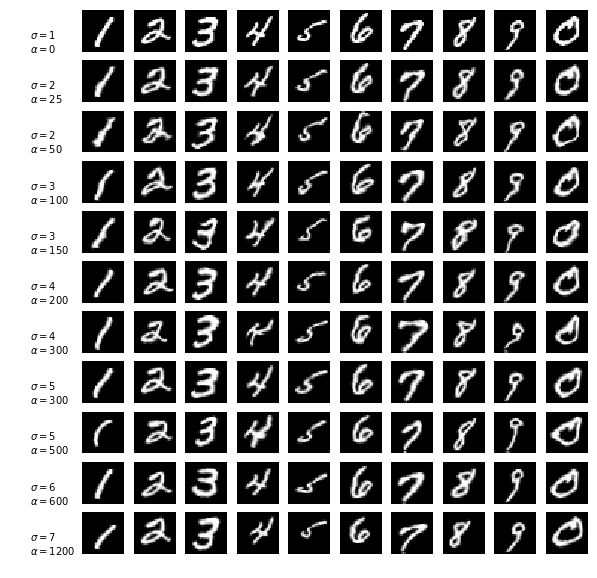

In [6]:
sigma_alpha = [
    (1, 0),
    (2, 25),
    (2, 50),
    (3, 100),
    (3, 150),
    (4, 200),
    (4, 300),
    (5, 300),
    (5, 500),
    (6, 600),
    (7, 1200),
]
nsamp = len(sigma_alpha)
np.random.seed(0)

plt.figure(figsize=(10,10))
for i, (sigma, alpha) in enumerate(sigma_alpha):
    print('\rOn %d/%d'%(i+1,len(sigma_alpha)), end=''); sys.stdout.flush()
    plt.subplot(len(sigma_alpha), nsamp, nsamp*i + 1)
    plt.text(0,0,r'$\sigma = $%d'%sigma + '\n' + r'$\alpha = $%d'%alpha)
    plt.axis('off')
    for j in range(1, nsamp):
        plt.subplot(len(sigma_alpha), nsamp, nsamp*i + j + 1)
        plt.imshow(elastic_transform(Xs[2*j+1], sigma, alpha)[:,:,0], cmap='gray')
        plt.axis('off')
plt.savefig(os.path.join(data_dir, 'mnist-examples.png'), bbox_inches='tight')
plt.show()

## Do the Augmentation

In [7]:
def elastic_augment(Xs, ys, nsamp):
    x_select = np.random.choice(range(len(Xs)), nsamp, replace=True)
    a_select = np.random.choice(range(len(sigma_alpha)), nsamp, replace=True)
    Xas = []
    yas = []
    for i in range(nsamp):
        print('\rOn %d/%d'%(i+1, nsamp), end=''); sys.stdout.flush()
        x = Xs[x_select[i]]
        sigma, alpha = sigma_alpha[a_select[i]]
        xa = elastic_transform(x, sigma, alpha)
        Xas.append(xa)
        yas.append(ys[x_select[i]])
    print()
    Xas = np.array(Xas).astype('f4')
    yas = np.array(yas).astype('i4')
    return Xas, yas

np.random.seed(0)

# Generate offline dataset and validation set from first 10k images
Xtr, ytr = elastic_augment(Xs[:9000], ys[:9000], 50000)
Xva, yva = elastic_augment(Xs[9000:10000], ys[9000:10000], 10000)

# Generate test set from test images
Xte, yte = elastic_augment(Xt, yt, 10000)

# Generate online dataset from remaining training images
Xon, yon = elastic_augment(Xs[10000:], ys[10000:], 500000)

On 50000/50000
On 10000/10000
On 10000/10000
On 500000/500000


In [36]:
with h5py.File(os.path.join(data_dir, 'mnist-aug500k.hdf5'), 'w') as f:
    f.create_dataset('Xtr', data=Xtr)
    f.create_dataset('ytr', data=ytr)
    f.create_dataset('Xva', data=Xva)
    f.create_dataset('yva', data=yva)
    f.create_dataset('Xte', data=Xte)
    f.create_dataset('yte', data=yte)
    f.create_dataset('Xt', data=Xt)
    f.create_dataset('yt', data=yt)

with h5py.File(os.path.join(data_dir, 'mnist-aug500k-ON.hdf5'), 'w') as f:
    f.create_dataset('X', data=Xon)
    f.create_dataset('y', data=yon)

## Load the Data File

Data  min: 0.000000 - max: 1.000000 - dims: (500000, 28, 28, 1)
Label min: 0 - max: 9 - dims: (500000,)


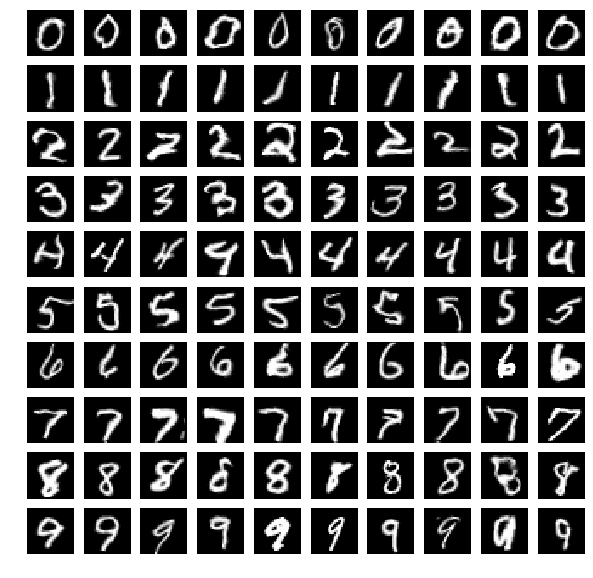

In [37]:
f = h5py.File(os.path.join(data_dir, 'mnist-aug500k-ON.hdf5'), 'r')
Xs = f['X']
ys = f['y']

print('Data  min: %f - max: %f - dims:'%(np.min(Xs), np.max(Xs)), Xs.shape)
print('Label min: %d - max: %d - dims:'%(np.min(ys), np.max(ys)), ys.shape)

plt.figure(figsize=(10,10))
for i in range(10):
    locs = np.where(ys[:1000] == i)[0][:10]
    for j, l in enumerate(locs):
        plt.subplot(10, 10, 10*i+j+1)
        plt.imshow(Xs[l,:,:,0], cmap='gray')
        plt.axis('off')
plt.savefig(os.path.join(data_dir, 'mnist-aug500k-examples.png'), bbox_inches='tight')
plt.show()

f.close()

## Other Imperfections for "Data Distribution Changes"

In [3]:
f = h5py.File(os.path.join(data_dir, 'mnist-aug500k-ON.hdf5'), 'r')
Xs = f['X']
ys = f['y']

def plot_examples(func, *args, **kwargs):
    np.random.seed(0)
    xx = func(Xs[:1000], *args, **kwargs)
    plt.figure(figsize=(10,10))
    for i in range(10):
        locs = np.where(ys[:1000] == i)[0][:10]
        for j, l in enumerate(locs):
            plt.subplot(10, 10, 10*i+j+1)
            plt.imshow(xx[l,:,:,0], cmap='gray', vmin=0, vmax=1)
            plt.axis('off')
    plt.savefig(os.path.join(data_dir, 'mnist-aug500k-%s-examples.png'%func.__name__), bbox_inches='tight')
    plt.show()

### Class Distribution

In [4]:
def class_distribution_permutation(imgs, labels, spread, eps):
    """
    Generates a permutation of the samples to group samples more by class.
       
    Parameters:
        @imgs: The input images (dimensions - Batch Size x Height x Width x Channels).
        @labels: The sample labels (1-dimensional array; assumes labels 0..c-1 for c classes).
        @spread: Determines how intermixed the classes are with each other (1 is minor mixing; >3 is moderate mixing).
        @eps: Probability of randomly uniformly assigning a ranking (so there isn't a perfect centering of data).
       
    Returns:
        The transformed dataset, a tuple of same size as (@imgs, @labels).
    """
    n = len(labels)
    c = np.max(labels) + 1
    center = np.random.uniform(size=c)
    sigma = spread / c
    ranking = [10 + center[label] + np.random.randn() * sigma if np.random.rand() > eps else np.random.uniform() for label in labels]
    ranking = np.argsort(np.fmod(ranking, 1))
    return imgs[ranking], labels[ranking]

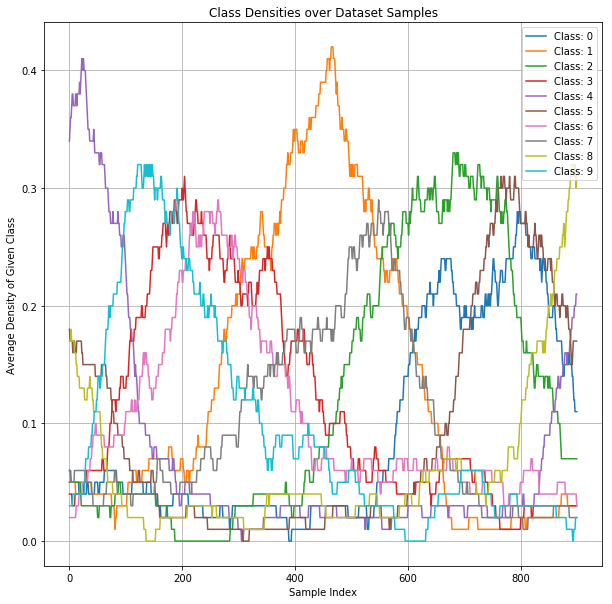

In [5]:
cdpx, cdpy = class_distribution_permutation(Xs[:1000], ys[:1000], spread=1.0, eps=0.3)
w = 100
plt.figure(figsize=(10,10))
for label in range(np.max(ys[:1000]) + 1):
    cum = np.cumsum(cdpy == label)
    avg = (cum[w:] - cum[:-w]) / w
    plt.plot(avg, label='Class: %d'%label)
plt.xlabel('Sample Index')
plt.ylabel('Average Density of Given Class')
plt.title('Class Densities over Dataset Samples')
plt.legend()
plt.grid()
plt.savefig(os.path.join(data_dir, 'mnist-aug500k-class-densities-examples.png'), bbox_inches='tight')
plt.show()

### Translate, Rotate, Scale

In [6]:
def add_spatial_transform(imgs, sx_std, sy_std, rot_std, tx_std, ty_std):
    """
    Adds a spatial transform to the input images.
       
    Parameters:
        @imgs: The input images (dimensions - Batch Size x Height x Width x Channels).
        @sx_std: Standard deviation of the natural log of the x-scale factor.
        @sy_std: Standard deviation of the natural log of the y-scale factor.
        @rot_std: Standard deviation of the rotation angle in degrees.
        @tx_std: Standard deviation of the x-dimension translation in pixels.
        @ty_std: Standard deviation of the y-dimension translation in pixels.
       
    Returns:
        The transformed images, same dimensions as @imgs.
    """
    xmin, xmax = np.min(imgs), np.max(imgs)
    nsamp, H, W, C = imgs.shape
    dx = np.clip(np.round(np.exp(np.random.randn(nsamp) * sx_std) * W).astype('i4'), H//2, 2*H)
    dy = np.clip(np.round(np.exp(np.random.randn(nsamp) * sy_std) * H).astype('i4'), W//2, 2*W)
    rot = np.random.randn(nsamp) * rot_std
    tx = np.random.randn(nsamp) * tx_std
    ty = np.random.randn(nsamp) * ty_std
    for i, img in enumerate(imgs):
        #print('\rOn %d'%i,end='')
        stage = np.zeros((2*H, 2*W, C))
        img = cv2.resize(img, (dx[i], dy[i]))
        if len(img.shape) != 3: img = img[:,:,np.newaxis]
        stage[H-dy[i]//2:H+dy[i]-dy[i]//2, W-dx[i]//2:W+dx[i]-dx[i]//2, :] = img
        stage = ndimage.rotate(stage, angle=rot[i], reshape=False)
        stage = ndimage.shift(stage, shift=(ty[i], tx[i], 0))
        imgs[i] = stage[H-H//2:2*H-H//2, W-W//2:2*W-W//2, :]
    return np.clip(imgs, xmin, xmax)

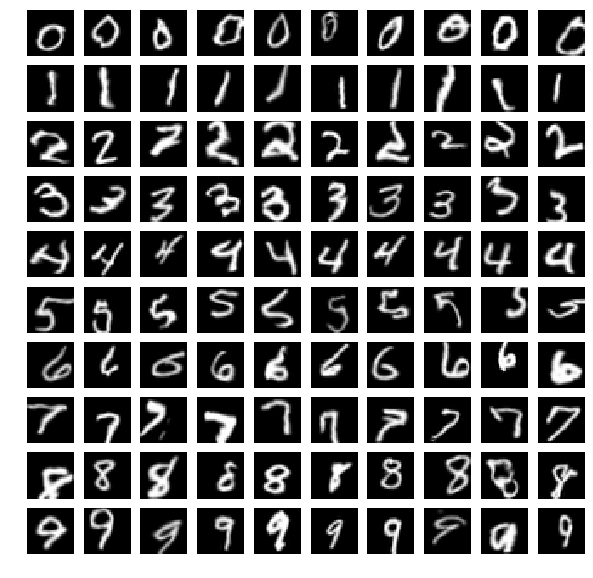

In [7]:
plot_examples(add_spatial_transform, sx_std=0.1, sy_std=0.1, rot_std=10, tx_std=2, ty_std=2)

### Background Gradients

In [8]:
def add_background_gradients(imgs, contrast_min, contrast_max, offset_min, offset_max, dev_max):
    """
    Adds a background gradient to the input images.
       
    Parameters:
        @imgs: The input images (dimensions - Batch Size x Height x Width x Channels).
        @contrast_min: Minimum scaling on pixel brightness differences.
        @contrast_max: Maximum scaling on pixel brightness differences.
        @offset_min: Minimum background offset at center of image.
        @offset_max: Maximum background offset at center of image.
        @dev_max: Maximum deviation of background offset from one corner to the other of an image.
       
    Returns:
        The transformed images, same dimensions as @imgs.
    """
    xmin, xmax = np.min(imgs), np.max(imgs)
    xr = np.transpose(imgs, (0,3,1,2)).reshape((-1, imgs.shape[1], imgs.shape[2]))
    shape = xr.shape
    
    # Generate contrasts and offsets
    contrast = np.random.uniform(contrast_min, contrast_max, size=(imgs.shape[0], 1, 1, imgs.shape[3]))
    offset = np.random.uniform(offset_min, offset_max, size=(shape[0], 1, 1))
    
    # Generate normal vectors to the gradient plane in two pieces: theta and rho
    theta = np.random.uniform(0, np.pi, size=shape[0])
    rho   = np.random.uniform(-np.pi/4, np.pi/4, size=shape[0])
    a = (np.sin(rho) * np.cos(theta))[:,np.newaxis,np.newaxis]
    b = (np.sin(rho) * np.sin(theta))[:,np.newaxis,np.newaxis]
    c = (np.cos(rho))[:,np.newaxis,np.newaxis]
    
    # Generate xy grid
    x = np.arange(-dev_max/2, dev_max/2 + 1e-8, dev_max / (shape[2] - 1))
    y = np.arange(-dev_max/2, dev_max/2 + 1e-8, dev_max / (shape[1] - 1))
    xgrid = np.tile(np.tile(x[np.newaxis,:], (shape[1], 1)), (shape[0],1,1))
    ygrid = np.tile(np.tile(y[:,np.newaxis], (1, shape[2])), (shape[0],1,1))
    
    # Generate full gradient and return
    ns = offset + (a * xgrid + b * ygrid) / c
    ns = np.transpose(ns.reshape((imgs.shape[0], imgs.shape[3], imgs.shape[1], imgs.shape[2])), (0,2,3,1))
    return np.clip(imgs * contrast + ns, xmin, xmax)

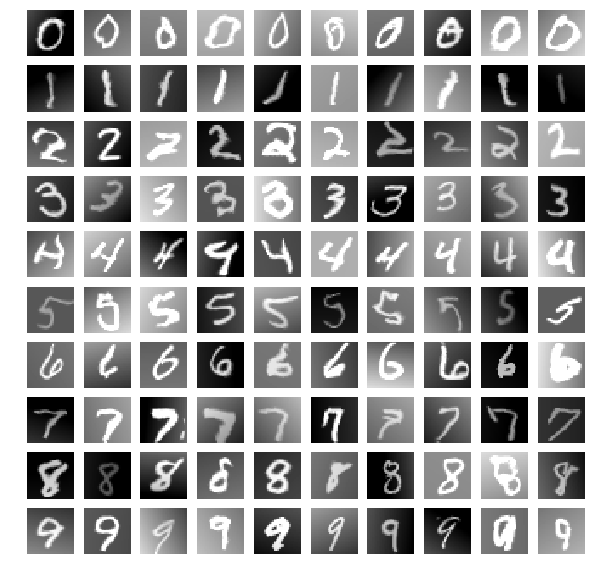

In [9]:
plot_examples(add_background_gradients, contrast_min=0.3, contrast_max=1.0, offset_min=0.0, offset_max=0.7, dev_max=0.5)

### White Noise

In [10]:
def add_white_noise(imgs, sigma_min, sigma_max):
    """
    Adds white noise to the input images. For a given image, its Gaussian noise standard deviation
    is chosen log-space uniformly between @sigma_min and @sigma_max.
       
    Parameters:
        @imgs: The input images (dimensions - Batch Size x Height x Width x Channels).
        @sigma_min: Minimum Gaussian noise standard deviation.
        @sigma_max: Maximum Gaussian noise standard deviation.
       
    Returns:
        The transformed images, same dimensions as @imgs.
    """
    xmin, xmax = np.min(imgs), np.max(imgs)
    sigma_min = max(sigma_min, 1e-8)
    sigma_max = max(sigma_max, 1e-8)
    sigmas = np.exp(np.random.uniform(np.log(sigma_min), np.log(sigma_max), size=(imgs.shape[0], 1, 1, 1)))
    ns = np.random.randn(*imgs.shape) * sigmas
    return np.clip(imgs + ns, xmin, xmax)

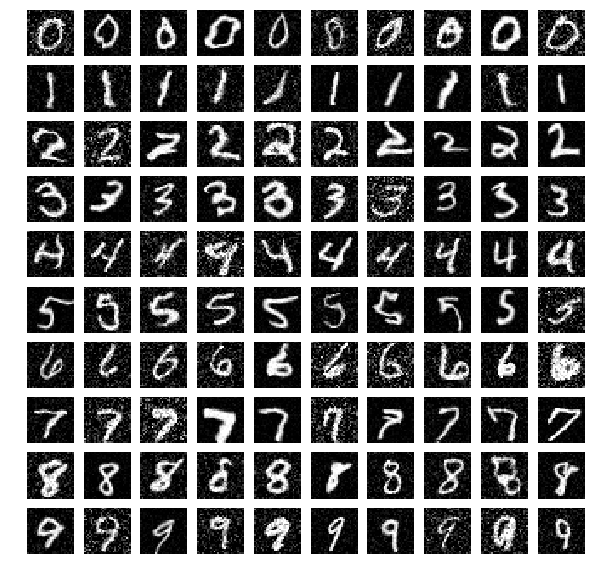

In [11]:
plot_examples(add_white_noise, sigma_min=0.03, sigma_max=0.3)

## Combine the Transforms

In [12]:
def add_combined_transforms(imgs, labels,
        bool_cdp, spread, eps,
        bool_st, sx_std, sy_std, rot_std, tx_std, ty_std,
        bool_bg, contrast_min, contrast_max, offset_min, offset_max, dev_max,
        bool_wn, sigma_min, sigma_max):
    bs = 100
    if bool_cdp: imgs, labels = class_distribution_permutation(imgs, labels, spread, eps)
    for i in range(0, len(labels), bs):
        if bool_st: imgs[i:i+bs] = add_spatial_transform(imgs[i:i+bs], sx_std, sy_std, rot_std, tx_std, ty_std)
        if bool_bg: imgs[i:i+bs] = add_background_gradients(imgs[i:i+bs], contrast_min, contrast_max, offset_min, offset_max, dev_max)
        if bool_wn: imgs[i:i+bs] = add_white_noise(imgs[i:i+bs], sigma_min, sigma_max)
    return imgs, labels

In [13]:
parameter_distributions = {
    'bool_cdp': ([True, False], [0.5, 0.5]),
    'spread': ([1.0, 3.0], [0.5, 0.5]),
    'eps': ([0.0, 0.1, 0.2, 0.3], [0.25, 0.25, 0.25, 0.25]),
    'bool_st': ([True, False], [0.5, 0.5]),
    'sx_std': ([0.0, 0.05, 0.1], [0.2, 0.4, 0.4]),
    'sy_std': ([0.0, 0.05, 0.1], [0.2, 0.4, 0.4]),
    'rot_std': ([0, 5, 10], [0.2, 0.4, 0.4]),
    'tx_std': ([0, 1, 2], [0.2, 0.4, 0.4]),
    'ty_std': ([0, 1, 2], [0.2, 0.4, 0.4]),
    'bool_bg': ([True, False], [0.5, 0.5]),
    'contrast_min': ([0.3, 0.7], [0.5, 0.5]),
    'contrast_max': ([1.0], [1.0]),
    'offset_min': ([0.0, 0.3], [0.8, 0.2]),
    'offset_max': ([0.5, 0.7], [0.2, 0.8]),
    'dev_max': ([0.01, 0.2, 0.5], [0.2, 0.4, 0.4]),
    'bool_wn': ([True, False], [0.5, 0.5]),
    'sigma_min': ([0.0, 0.03, 0.1], [0.2, 0.4, 0.4]),
    'sigma_max': ([0.1, 0.3], [0.5, 0.5]),
}
for i in range(1):
    kwargs = {k:np.random.choice(v[0], p=v[1]) for k,v in parameter_distributions.items()}
    xx, yy = add_combined_transforms(Xs[:20], ys[:20], **kwargs)
    print(kwargs)

{'bool_cdp': True, 'spread': 1.0, 'eps': 0.1, 'bool_st': False, 'sx_std': 0.1, 'sy_std': 0.1, 'rot_std': 10, 'tx_std': 1, 'ty_std': 1, 'bool_bg': True, 'contrast_min': 0.7, 'contrast_max': 1.0, 'offset_min': 0.0, 'offset_max': 0.7, 'dev_max': 0.5, 'bool_wn': False, 'sigma_min': 0.1, 'sigma_max': 0.1}


## Generate the Distribution Shift Dataset (Large)

In [26]:
start_idx = 0
shift_idx = 10000
np.random.seed(0)
DSXs = [Xs[:start_idx]]
DSys = [ys[:start_idx]]
all_kwargs = []
for i in range(start_idx, len(Xs), shift_idx):
    kwargs = {k:np.random.choice(v[0], p=v[1]) for k,v in parameter_distributions.items()}
    all_kwargs.append(kwargs)
    print('On %d/%d:'%(i,len(Xs)), kwargs)
    xx, yy = add_combined_transforms(Xs[i:i+shift_idx], ys[i:i+shift_idx], **kwargs)
    assert np.min(xx) >= 0 and np.max(xx) <= 1
    DSXs.append(xx)
    DSys.append(yy)
DSXs = np.vstack(DSXs)
DSys = np.concatenate(DSys)
all_txs = np.array(list(map(str, all_kwargs)), dtype='S')

On 0/500000: {'bool_cdp': False, 'spread': 3.0, 'eps': 0.2, 'bool_st': False, 'sx_std': 0.05, 'sy_std': 0.1, 'rot_std': 5, 'tx_std': 2, 'ty_std': 2, 'bool_bg': True, 'contrast_min': 0.7, 'contrast_max': 1.0, 'offset_min': 0.0, 'offset_max': 0.7, 'dev_max': 0.01, 'bool_wn': True, 'sigma_min': 0.0, 'sigma_max': 0.3}
On 10000/500000: {'bool_cdp': True, 'spread': 3.0, 'eps': 0.3, 'bool_st': False, 'sx_std': 0.1, 'sy_std': 0.1, 'rot_std': 10, 'tx_std': 1, 'ty_std': 0, 'bool_bg': False, 'contrast_min': 0.7, 'contrast_max': 1.0, 'offset_min': 0.0, 'offset_max': 0.7, 'dev_max': 0.5, 'bool_wn': False, 'sigma_min': 0.0, 'sigma_max': 0.1}
On 20000/500000: {'bool_cdp': True, 'spread': 1.0, 'eps': 0.2, 'bool_st': False, 'sx_std': 0.1, 'sy_std': 0.1, 'rot_std': 5, 'tx_std': 1, 'ty_std': 0, 'bool_bg': False, 'contrast_min': 0.7, 'contrast_max': 1.0, 'offset_min': 0.0, 'offset_max': 0.7, 'dev_max': 0.5, 'bool_wn': False, 'sigma_min': 0.1, 'sigma_max': 0.3}
On 30000/500000: {'bool_cdp': False, 'spread'

On 260000/500000: {'bool_cdp': False, 'spread': 1.0, 'eps': 0.3, 'bool_st': True, 'sx_std': 0.05, 'sy_std': 0.1, 'rot_std': 0, 'tx_std': 1, 'ty_std': 2, 'bool_bg': False, 'contrast_min': 0.3, 'contrast_max': 1.0, 'offset_min': 0.0, 'offset_max': 0.7, 'dev_max': 0.01, 'bool_wn': True, 'sigma_min': 0.03, 'sigma_max': 0.3}
On 270000/500000: {'bool_cdp': False, 'spread': 3.0, 'eps': 0.0, 'bool_st': False, 'sx_std': 0.05, 'sy_std': 0.1, 'rot_std': 5, 'tx_std': 1, 'ty_std': 2, 'bool_bg': True, 'contrast_min': 0.7, 'contrast_max': 1.0, 'offset_min': 0.3, 'offset_max': 0.7, 'dev_max': 0.01, 'bool_wn': True, 'sigma_min': 0.1, 'sigma_max': 0.1}
On 280000/500000: {'bool_cdp': True, 'spread': 1.0, 'eps': 0.3, 'bool_st': True, 'sx_std': 0.1, 'sy_std': 0.1, 'rot_std': 10, 'tx_std': 1, 'ty_std': 1, 'bool_bg': True, 'contrast_min': 0.7, 'contrast_max': 1.0, 'offset_min': 0.0, 'offset_max': 0.7, 'dev_max': 0.2, 'bool_wn': True, 'sigma_min': 0.1, 'sigma_max': 0.3}
On 290000/500000: {'bool_cdp': False, '

In [28]:
f.close()

In [34]:
with h5py.File(os.path.join(data_dir, 'mnist-aug500k-DS.hdf5'), 'w') as f:
    f.create_dataset('X', data=DSXs)
    f.create_dataset('y', data=DSys)
    f.create_dataset('transforms', data=all_txs)

## Load the Distribution Shift Datafile

Data  min: 0.000000 - max: 1.000000 - dims: (500000, 28, 28, 1)
Label min: 0 - max: 9 - dims: (500000,)


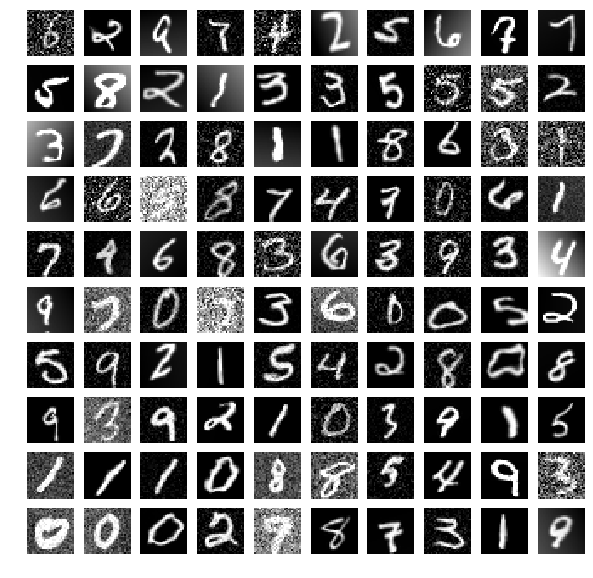

In [35]:
f = h5py.File(os.path.join(data_dir, 'mnist-aug500k-DS.hdf5'), 'r')
Xs = f['X']
ys = f['y']

print('Data  min: %f - max: %f - dims:'%(np.min(Xs), np.max(Xs)), Xs.shape)
print('Label min: %d - max: %d - dims:'%(np.min(ys), np.max(ys)), ys.shape)

plt.figure(figsize=(10,10))
np.random.seed(0)
get = np.random.choice(range(ys.size), 100, replace=False)
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(Xs[get[i],:,:,0], cmap='gray')
    plt.axis('off')
plt.savefig(os.path.join(data_dir, 'mnist-aug500k-DS-examples.png'), bbox_inches='tight')
plt.show()

f.close()

In [ ]:
f.close()

## Generate the Distribution Shift Dataset (Small)

In [15]:
f.close()
f = h5py.File(os.path.join(data_dir, 'mnist-aug500k-ON.hdf5'), 'r')
Xs = f['X']
ys = f['y']

with h5py.File(os.path.join(data_dir, 'mnist-aug500k-ON2.hdf5'), 'w') as f:
    f.create_dataset('X', data=Xs[:100000])
    f.create_dataset('y', data=ys[:100000])

In [16]:
from copy import deepcopy
kwargs_base = {
    'bool_cdp':True, 'spread':1.0, 'eps':0.3,
    'bool_st': True, 'sx_std':0.1, 'sy_std':0.1, 'rot_std':10, 'tx_std':2, 'ty_std':2,
    'bool_bg': True, 'contrast_min':0.3, 'contrast_max':1.0, 'offset_min':0.0, 'offset_max':0.7, 'dev_max':0.5,
    'bool_wn': True, 'sigma_min':0.03, 'sigma_max':0.3,
}

start_idx = 0
shift_idx = 10000
end_idx = 100000
np.random.seed(0)
DSXs = [Xs[:start_idx]]
DSys = [ys[:start_idx]]
all_kwargs = []
schedule = {
    'bool_cdp': [True, False, False, False, False, False, False, False, True, False],
    'bool_st' : [False, True, False, False, True, True, False, True, True, False],
    'bool_bg' : [False, False, True, False, False, True, True, True, True, False],
    'bool_wn' : [False, False, False, True, True, False, True, True, True, False],
}
j = 0
for i in range(start_idx, end_idx, shift_idx):
    kwargs = deepcopy(kwargs_base)
    kwargs['bool_cdp'] = schedule['bool_cdp'][j]
    kwargs['bool_st'] = schedule['bool_st'][j]
    kwargs['bool_bg'] = schedule['bool_bg'][j]
    kwargs['bool_wn'] = schedule['bool_wn'][j]
    all_kwargs.append(kwargs)
    print('On %d/%d:'%(i,end_idx), kwargs)
    xx, yy = add_combined_transforms(Xs[i:i+shift_idx], ys[i:i+shift_idx], **kwargs)
    assert np.min(xx) >= 0 and np.max(xx) <= 1
    DSXs.append(xx)
    DSys.append(yy)
    j += 1
DSXs = np.vstack(DSXs)
DSys = np.concatenate(DSys)
all_txs = np.array(list(map(str, all_kwargs)), dtype='S')

On 0/500000: {'bool_cdp': True, 'spread': 1.0, 'eps': 0.3, 'bool_st': False, 'sx_std': 0.1, 'sy_std': 0.1, 'rot_std': 10, 'tx_std': 2, 'ty_std': 2, 'bool_bg': False, 'contrast_min': 0.3, 'contrast_max': 1.0, 'offset_min': 0.0, 'offset_max': 0.7, 'dev_max': 0.5, 'bool_wn': False, 'sigma_min': 0.03, 'sigma_max': 0.3}
On 10000/500000: {'bool_cdp': False, 'spread': 1.0, 'eps': 0.3, 'bool_st': True, 'sx_std': 0.1, 'sy_std': 0.1, 'rot_std': 10, 'tx_std': 2, 'ty_std': 2, 'bool_bg': False, 'contrast_min': 0.3, 'contrast_max': 1.0, 'offset_min': 0.0, 'offset_max': 0.7, 'dev_max': 0.5, 'bool_wn': False, 'sigma_min': 0.03, 'sigma_max': 0.3}
On 20000/500000: {'bool_cdp': False, 'spread': 1.0, 'eps': 0.3, 'bool_st': False, 'sx_std': 0.1, 'sy_std': 0.1, 'rot_std': 10, 'tx_std': 2, 'ty_std': 2, 'bool_bg': True, 'contrast_min': 0.3, 'contrast_max': 1.0, 'offset_min': 0.0, 'offset_max': 0.7, 'dev_max': 0.5, 'bool_wn': False, 'sigma_min': 0.03, 'sigma_max': 0.3}
On 30000/500000: {'bool_cdp': False, 'spr

In [17]:
f.close()

In [18]:
with h5py.File(os.path.join(data_dir, 'mnist-aug500k-DS2.hdf5'), 'w') as f:
    f.create_dataset('X', data=DSXs)
    f.create_dataset('y', data=DSys)
    f.create_dataset('transforms', data=all_txs)

## Load the Distribution Shift Datafile

Data  min: 0.000000 - max: 1.000000 - dims: (100000, 28, 28, 1)
Label min: 0 - max: 9 - dims: (100000,)


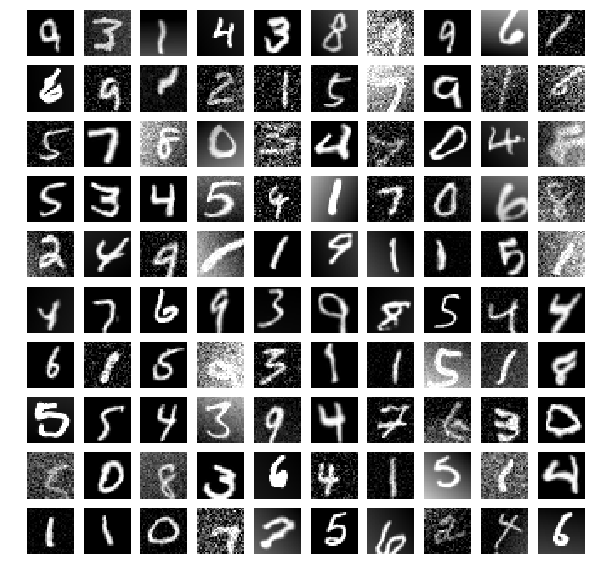

In [19]:
f = h5py.File(os.path.join(data_dir, 'mnist-aug500k-DS2.hdf5'), 'r')
Xs = f['X']
ys = f['y']

print('Data  min: %f - max: %f - dims:'%(np.min(Xs), np.max(Xs)), Xs.shape)
print('Label min: %d - max: %d - dims:'%(np.min(ys), np.max(ys)), ys.shape)

plt.figure(figsize=(10,10))
np.random.seed(0)
get = np.random.choice(range(ys.size), 100, replace=False)
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(Xs[get[i],:,:,0], cmap='gray')
    plt.axis('off')
plt.savefig(os.path.join(data_dir, 'mnist-aug500k-DS2-examples.png'), bbox_inches='tight')
plt.show()

f.close()

In [ ]:
f.close()